# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present;
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant).

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [1]:
# This code imports some libraries that you will need.
# You should not need to modify it, though you are expected to make other imports later in your code.

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import time
import collections

# Pandas for overview
import pandas as pd
import random
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import tree
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score

# Plot setup
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns
# mpl.rc('axes', labelsize=7)
# mpl.rc('xtick', labelsize=6)
# mpl.rc('ytick', labelsize=6)
# mpl.rc('figure', dpi=240)
plt.close('all')

import seaborn as sns

In [2]:
# set random seed for all instances of random
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

### Loading in the Dataset

In [3]:
df = pd.read_csv(r"./assignment2_data_2024.csv")
df.head()

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
0,malignant,15.494653829645529,15.902542,103.008265,776.437239,0.104239,0.168660,0.170572,0.085668,0.205053,...,0.653654,1.096678,4.962255,80.619370,0.006669,0.034950,0.043568,0.013765,0.024093,0.004928
1,malignant,16.229870799611437,18.785613,105.176755,874.712003,0.091843,0.092548,0.081681,0.053670,0.180435,...,0.445451,1.043931,3.005373,50.407958,0.006352,0.019998,0.025324,0.012172,0.018084,0.003582
2,malignant,16.34567074196476,20.114076,107.083804,872.563251,0.099924,0.123799,0.128788,0.078310,0.189756,...,0.549625,1.057447,3.643671,62.732851,0.006757,0.031325,0.034350,0.015150,0.021459,0.004066
3,maligant,13.001009157806651,19.876997,85.889775,541.281012,0.113423,0.173069,0.146214,0.069574,0.212078,...,0.430693,1.202955,3.051434,33.614356,0.007930,0.044881,0.042972,0.014556,0.035670,0.005981
4,malignant,16.416060073302194,17.397533,107.857386,891.516818,0.097321,0.111530,0.125971,0.068575,0.179562,...,0.525532,1.045900,3.747194,59.164555,0.008718,0.024231,0.039763,0.014202,0.019236,0.004115


In [4]:
# Extract feature and labels names
feature_names = df.columns[1:]
target = df.columns[0]

### Preliminary Visualization of the Dataset

In [5]:
# Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         220 non-null    float64
 7   mean concavity           220 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            220 non-null    float64
 10  mean fractal dimension   220 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            220 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area error               2

We will first do a preliminary describe with the dirty data and after we clean these values, we can visualize the dataset again. (This will be done in step 2)

In [6]:
# Describe to show the statistics of the data
df.describe()

,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,219.000000,220.000000
mean,18.991963,89.866240,620.956227,0.096480,0.102879,0.085281,0.046867,0.181850,0.103957,0.393337,1.217593,2.775090,37.781034,0.007076,0.025514,0.031901,0.011762,0.020901,0.003873
std,1.427635,7.366180,106.419871,0.004961,0.019819,0.026911,0.012548,0.010816,0.606979,0.075828,0.210182,0.579317,9.988655,0.001043,0.007345,0.014102,0.002422,0.003250,0.001259
min,15.349270,74.690886,-2.645499,0.084651,0.075184,0.050771,0.028701,0.157059,0.058922,0.298005,0.898026,2.059186,27.693748,0.004994,0.016907,0.018730,0.007253,0.016181,0.002631
25%,17.914319,84.911981,558.731832,0.092797,0.089531,0.066525,0.038106,0.174944,0.061139,0.343114,1.073344,2.394331,31.843894,0.006372,0.020530,0.025373,0.010336,0.018658,0.003225
50%,18.928256,88.587737,603.806128,0.096457,0.098517,0.075748,0.042761,0.180953,0.062557,0.367863,1.165727,2.610732,34.007608,0.006837,0.023147,0.028835,0.011357,0.020193,0.003555
75%,19.995859,93.066393,655.690435,0.099817,0.113276,0.098826,0.055337,0.186354,0.064184,0.420514,1.300769,3.003888,39.042484,0.007675,0.027733,0.033620,0.012669,0.022195,0.004046
max,24.430831,121.247839,1103.740620,0.113423,0.192880,0.201971,0.100467,0.226448,9.065897,0.712896,2.561348,5.903661,80.619370,0.011088,0.054950,0.163592,0.026554,0.041861,0.013251


Visualize the distribution of each numerical feature:

**Using density plots**

/var/folders/gg/27ydp9614p9cpq8pg5r7rklc0000gn/T/ipykernel_90235/2683962586.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = df, x = feature, hue = "label")


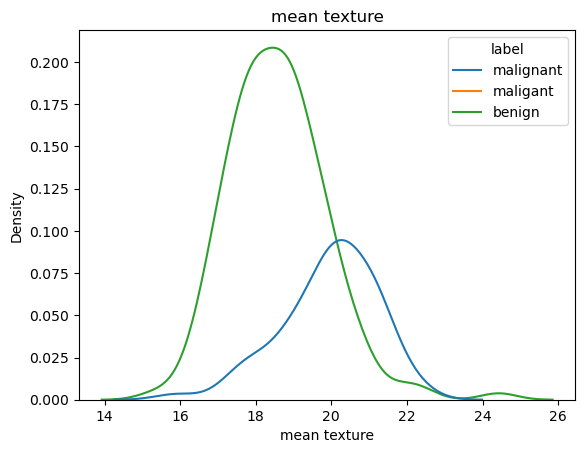

In [7]:
for feature in feature_names[1:]:
    sns.kdeplot(data = df, x = feature, hue = "label")
    plt.title(feature)
    plt.show()
    break

We notice that the label (target) data is dirty, we will first clean all the data, and then visualize the cleaned data.

### Data and Error handling

From the earlier point, we will clean the label (target) data.

In [8]:
# identify which are the erroneous values
df['label'].value_counts()

label
benign       154
malignant     65
maligant       1
Name: count, dtype: int64

In [9]:
# cleaning and inspecting the new label data
df['label'] = df["label"].str.replace("maligant","malignant")
df['label'].value_counts()

label
benign       154
malignant     66
Name: count, dtype: int64

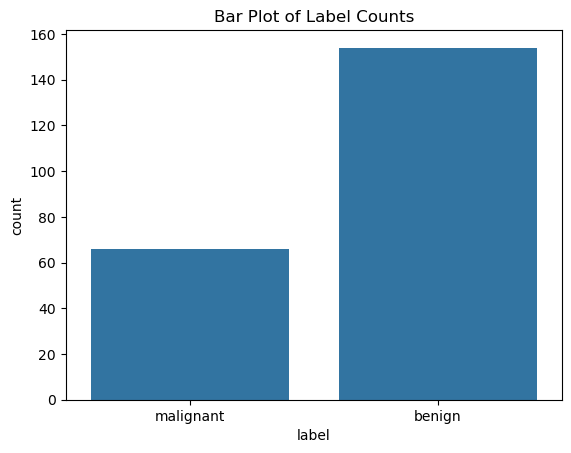

In [10]:
# bat plot of label to show target split
sns.countplot(data = df, x = "label")
plt.title('Bar Plot of Label Counts')
plt.show()

We notice that the column "mean radius" of not dtype float64, but an object. To know why, we will look look for the data that's not a number.

In [11]:
# Check for non-numeric numbers in "mean radius" column
for x in df["mean radius"].value_counts().index:
    if x.replace(".", "").isdigit() == False:
        print(x)

-14.292182467715936
n12.254518716420597


It can be seen that there are input errors and a negative value. Since the value is mean radius (a distance), it is impossible for the values to be negative.

In [12]:
df["mean radius"] = df["mean radius"].apply(lambda x: float(x[1:]) if ('-' in x) or ('n' in x) else float(x))
df["mean radius"]

0      15.494654
1      16.229871
2      16.345671
3      13.001009
4      16.416060
         ...    
215    13.618925
216    14.048464
217    12.879033
218    14.411991
219    12.704174
Name: mean radius, Length: 220, dtype: float64

We then check for null values in the data.

In [13]:
# Check for null values in the dataset
df.isnull().sum()

label                      0
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             1
fractal dimension error    0
dtype: int64

In [14]:
df[df["symmetry error"].isna()]

,label,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,...,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error
218,benign,14.411991,18.970674,93.423809,671.128126,0.086304,0.090118,0.070882,0.039482,0.175789,...,0.356964,1.030049,2.56017,35.435273,0.005784,0.022279,0.025244,0.00999,NaN,0.003255


Note: Imputation will be part of the preprocessing pipeline to account for data leakage.

### Visualization and Outlier Analysis

#### Visualization of data distirbutions

**Using histograms**

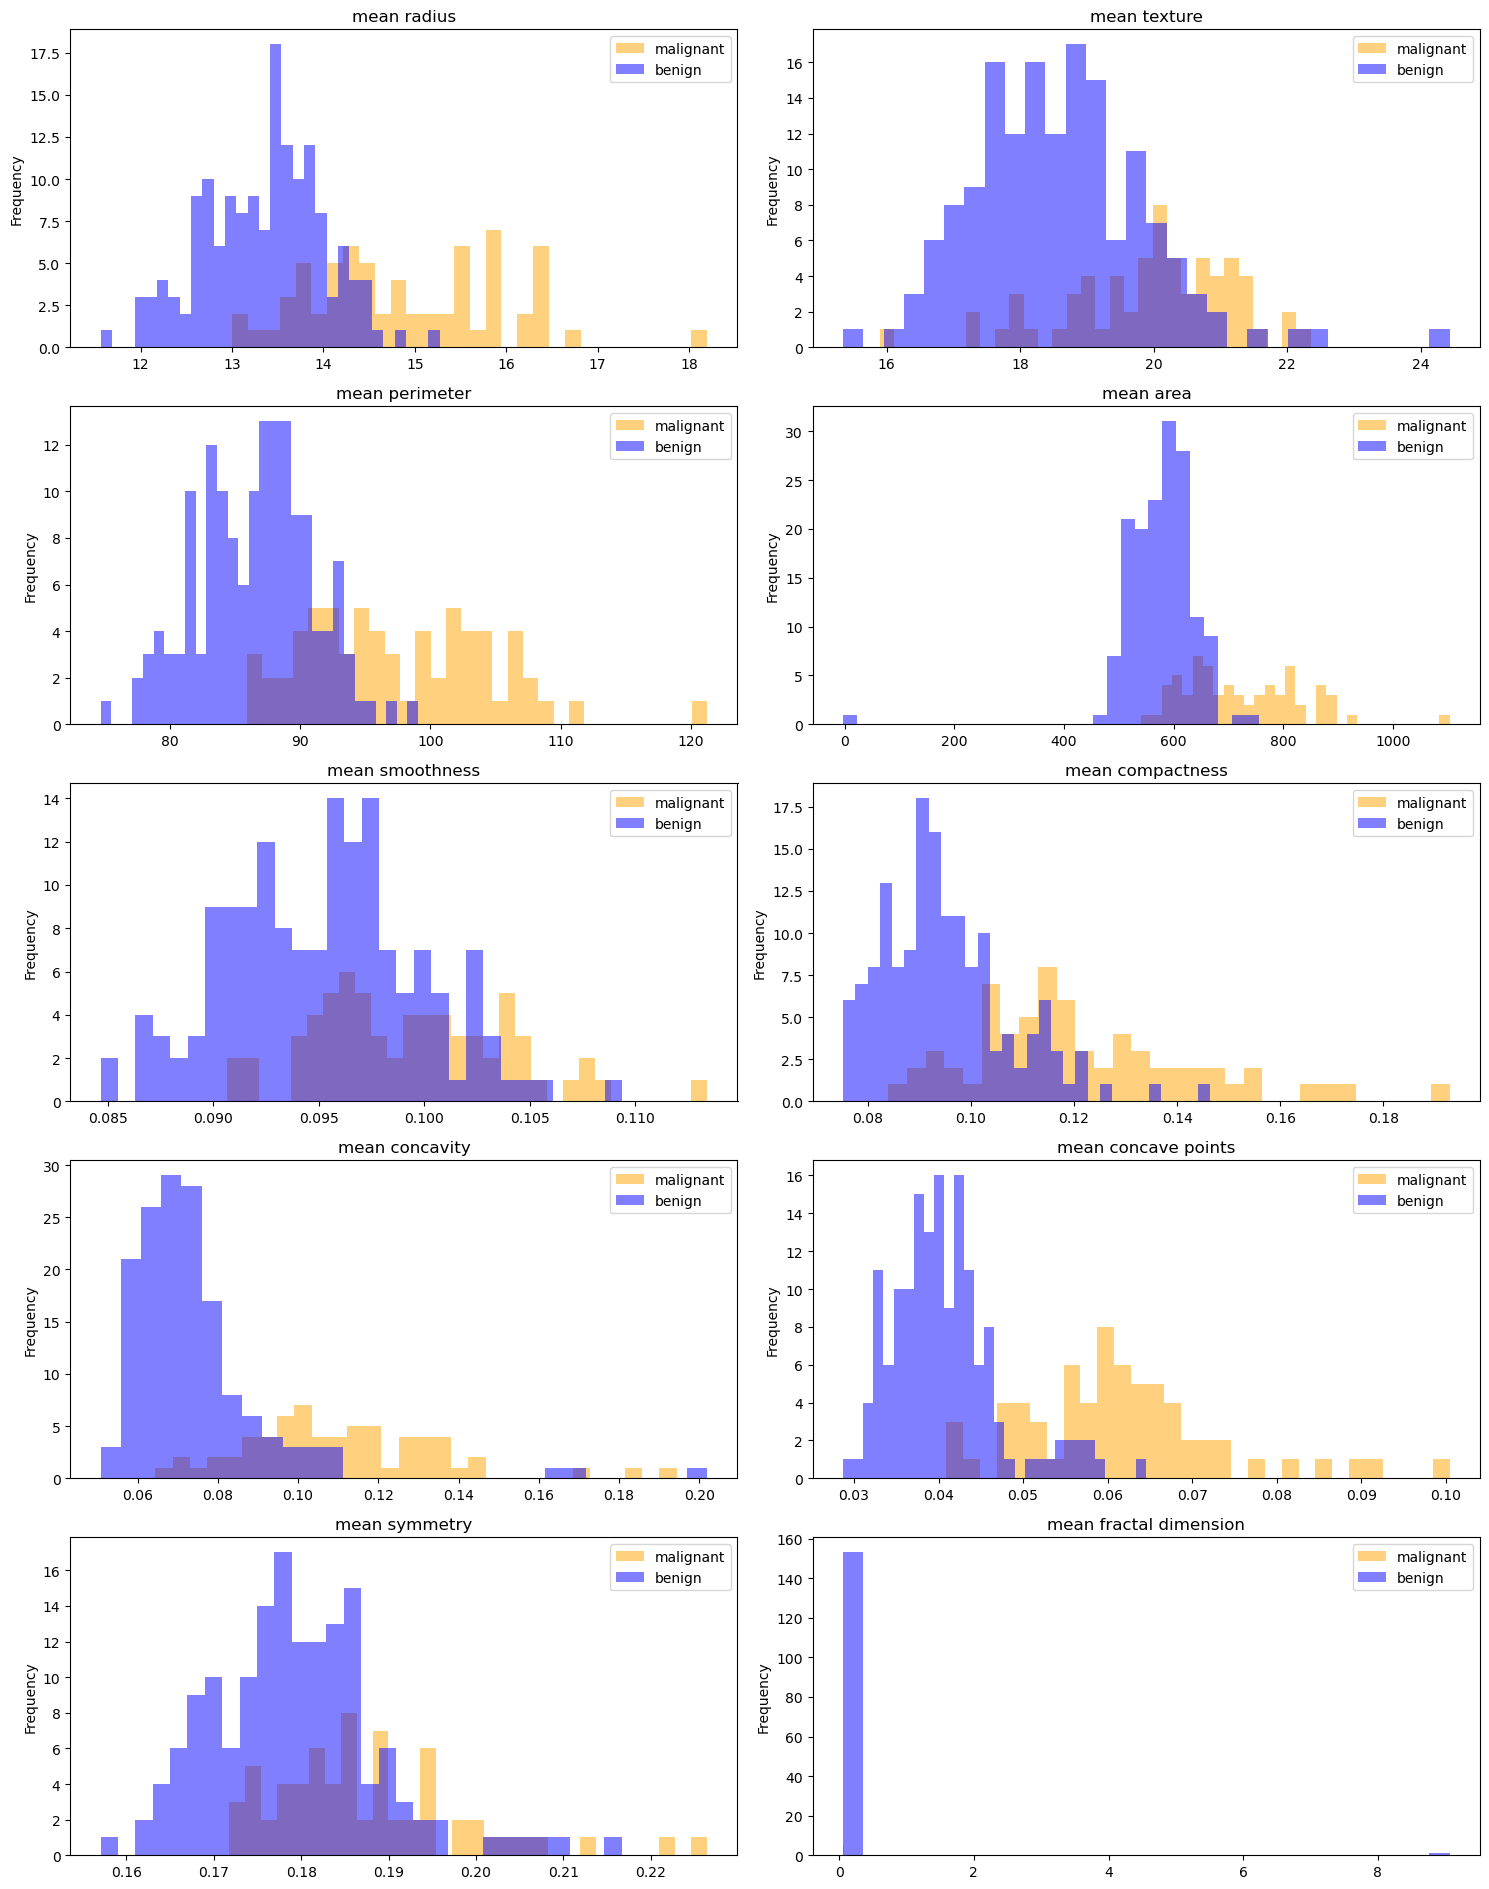

In [15]:
# Create subplots of mean features
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the figure size as needed

# Plotting the subplots
for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    ax = axs[i//2, i%2]
    class_0 = df[df['label'] == 'benign'][v]
    class_1 = df[df['label'] == 'malignant'][v]

    # plot the histograms
    ax.hist(class_1, bins = 30, alpha=0.5, label='malignant', color='orange')
    ax.hist(class_0, bins = 30, alpha=0.5, label='benign', color='blue')

    ax.set_title(v)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

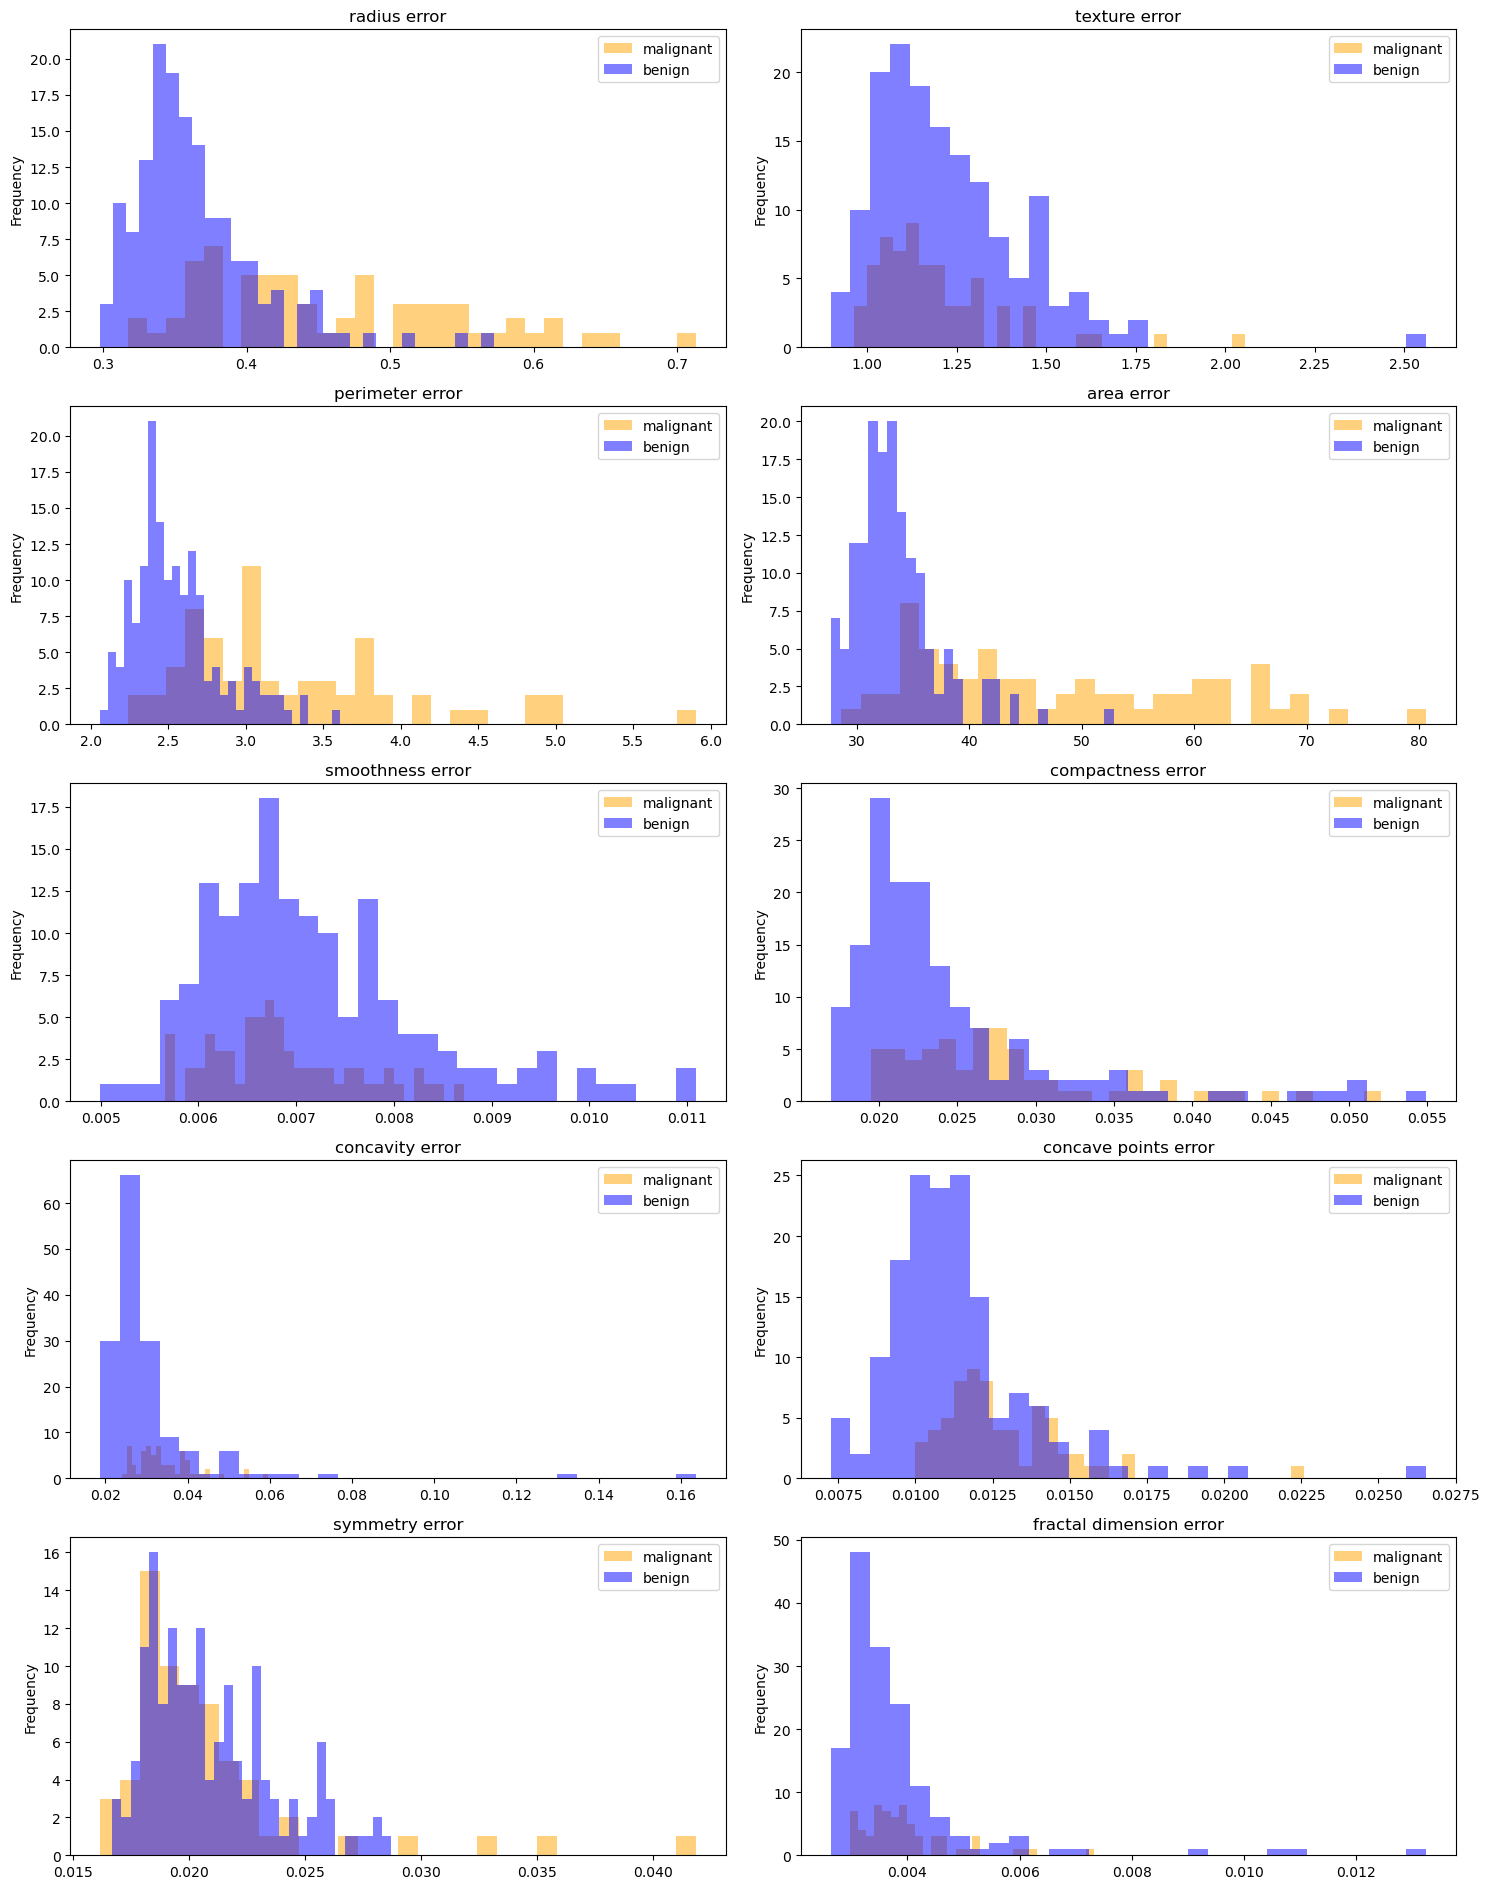

In [16]:
# Create subplots of mean features
fig, axs = plt.subplots(5, 2, figsize=(15, 20))  # Adjust the figure size as needed

# Plotting the subplots
for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    ax = axs[i//2, i%2]
    class_0 = df[df['label'] == 'benign'][v]
    class_1 = df[df['label'] == 'malignant'][v]

    # plot the histograms
    ax.hist(class_1, bins = 30, alpha=0.5, label='malignant', color='orange')
    ax.hist(class_0, bins = 30, alpha=0.5, label='benign', color='blue')

    ax.set_title(v)
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

#### Outlier analysis with violinplots

**Using violinplots and stripplots complementing distribution analysis (Added outside matplotlib)**

NOTE: Dots refer to the defintion of a statistical outlier where $\hat{x} ± 1.5 * IQR$


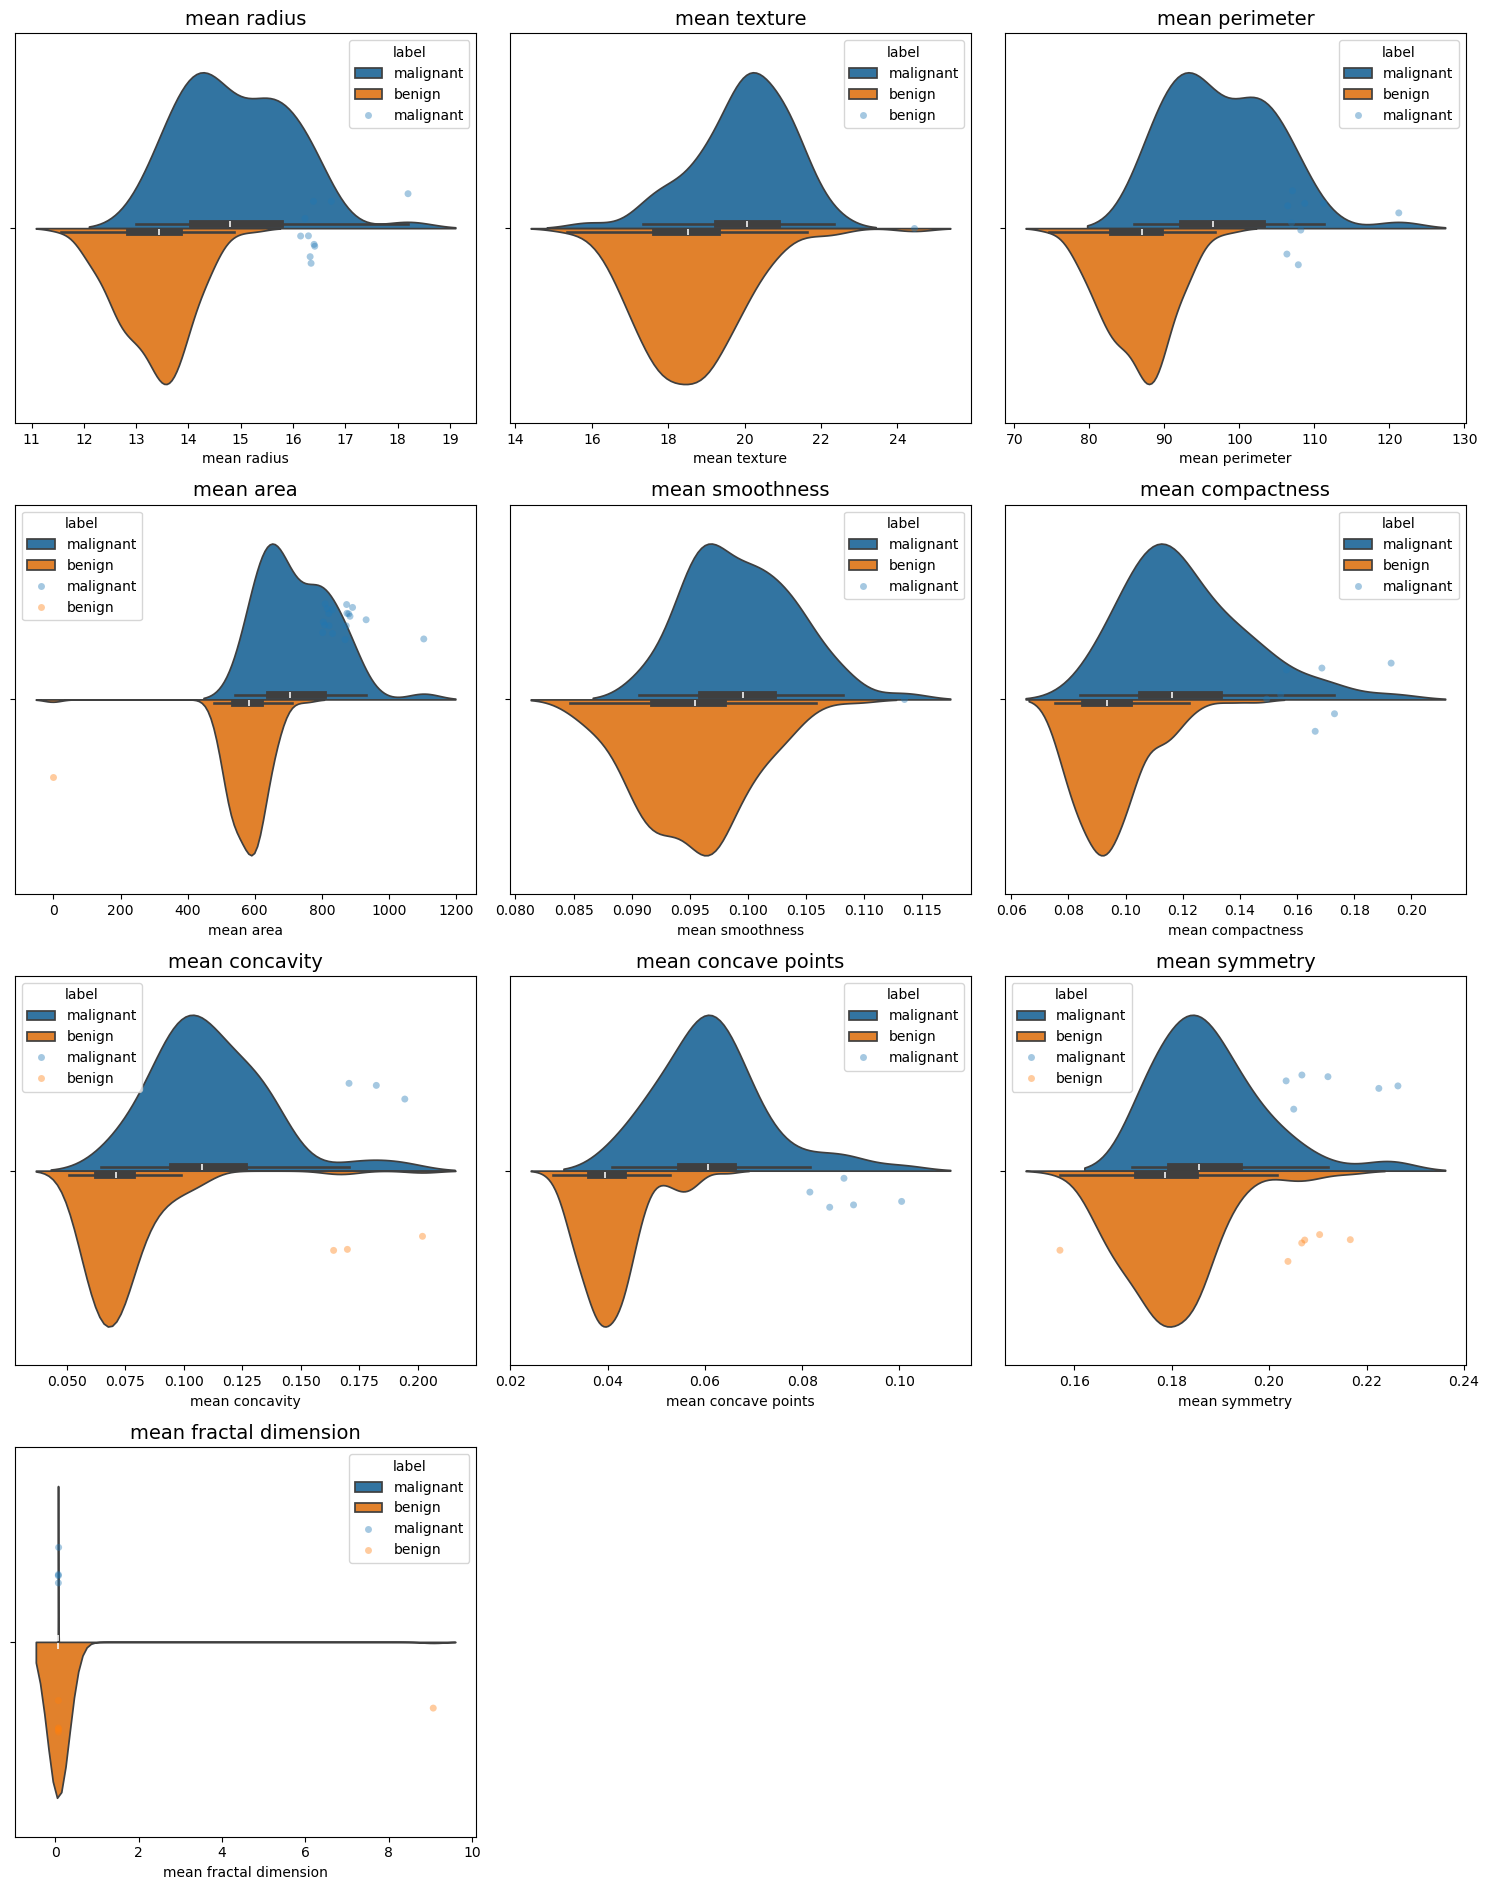

In [17]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) 

plt.show()


This plots the violinplots of both malignant and bening values w.r.t each outlier values for the mean measurement features. We will use the distributions to serve as guidance with the outliers to "eyeball" *unreasonable values*. This process will be repeated as well for the error measurement features.

In [18]:
# Removing outliers of the "mean" feautures by setting these as np.nan
# We will manually remove problematic outliers and replace these to be with np.nan to be imputed in step 2
df.loc[((df["mean radius"] > 18) & (df["label"] == 'malignant')), "mean radius"] = np.nan

df["mean perimeter"] = df["mean perimeter"].apply(lambda x: np.nan if x > 120 else x)

df["mean compactness"] = df["mean compactness"].apply(lambda x: np.nan if x > 0.16 else x)

df.loc[(df["mean area"] < 200) & (df["label"] == 'benign'), "mean area"] = np.nan
df.loc[(df["mean area"] > 850) & (df["label"] == 'malignant'), "mean area"] = np.nan

df.loc[(df["mean texture"] > 24) & (df["label"] == 'benign'), "mean texture"] = np.nan

df["mean symmetry"] = df["mean symmetry"].apply(lambda x: np.nan if x >= 0.20 else x)

df["mean concavity"] = df["mean concavity"].apply(lambda x: np.nan if x > 0.170 else x)

df["mean fractal dimension"] = df["mean fractal dimension"].apply(lambda x: np.nan if x > 1 else x)

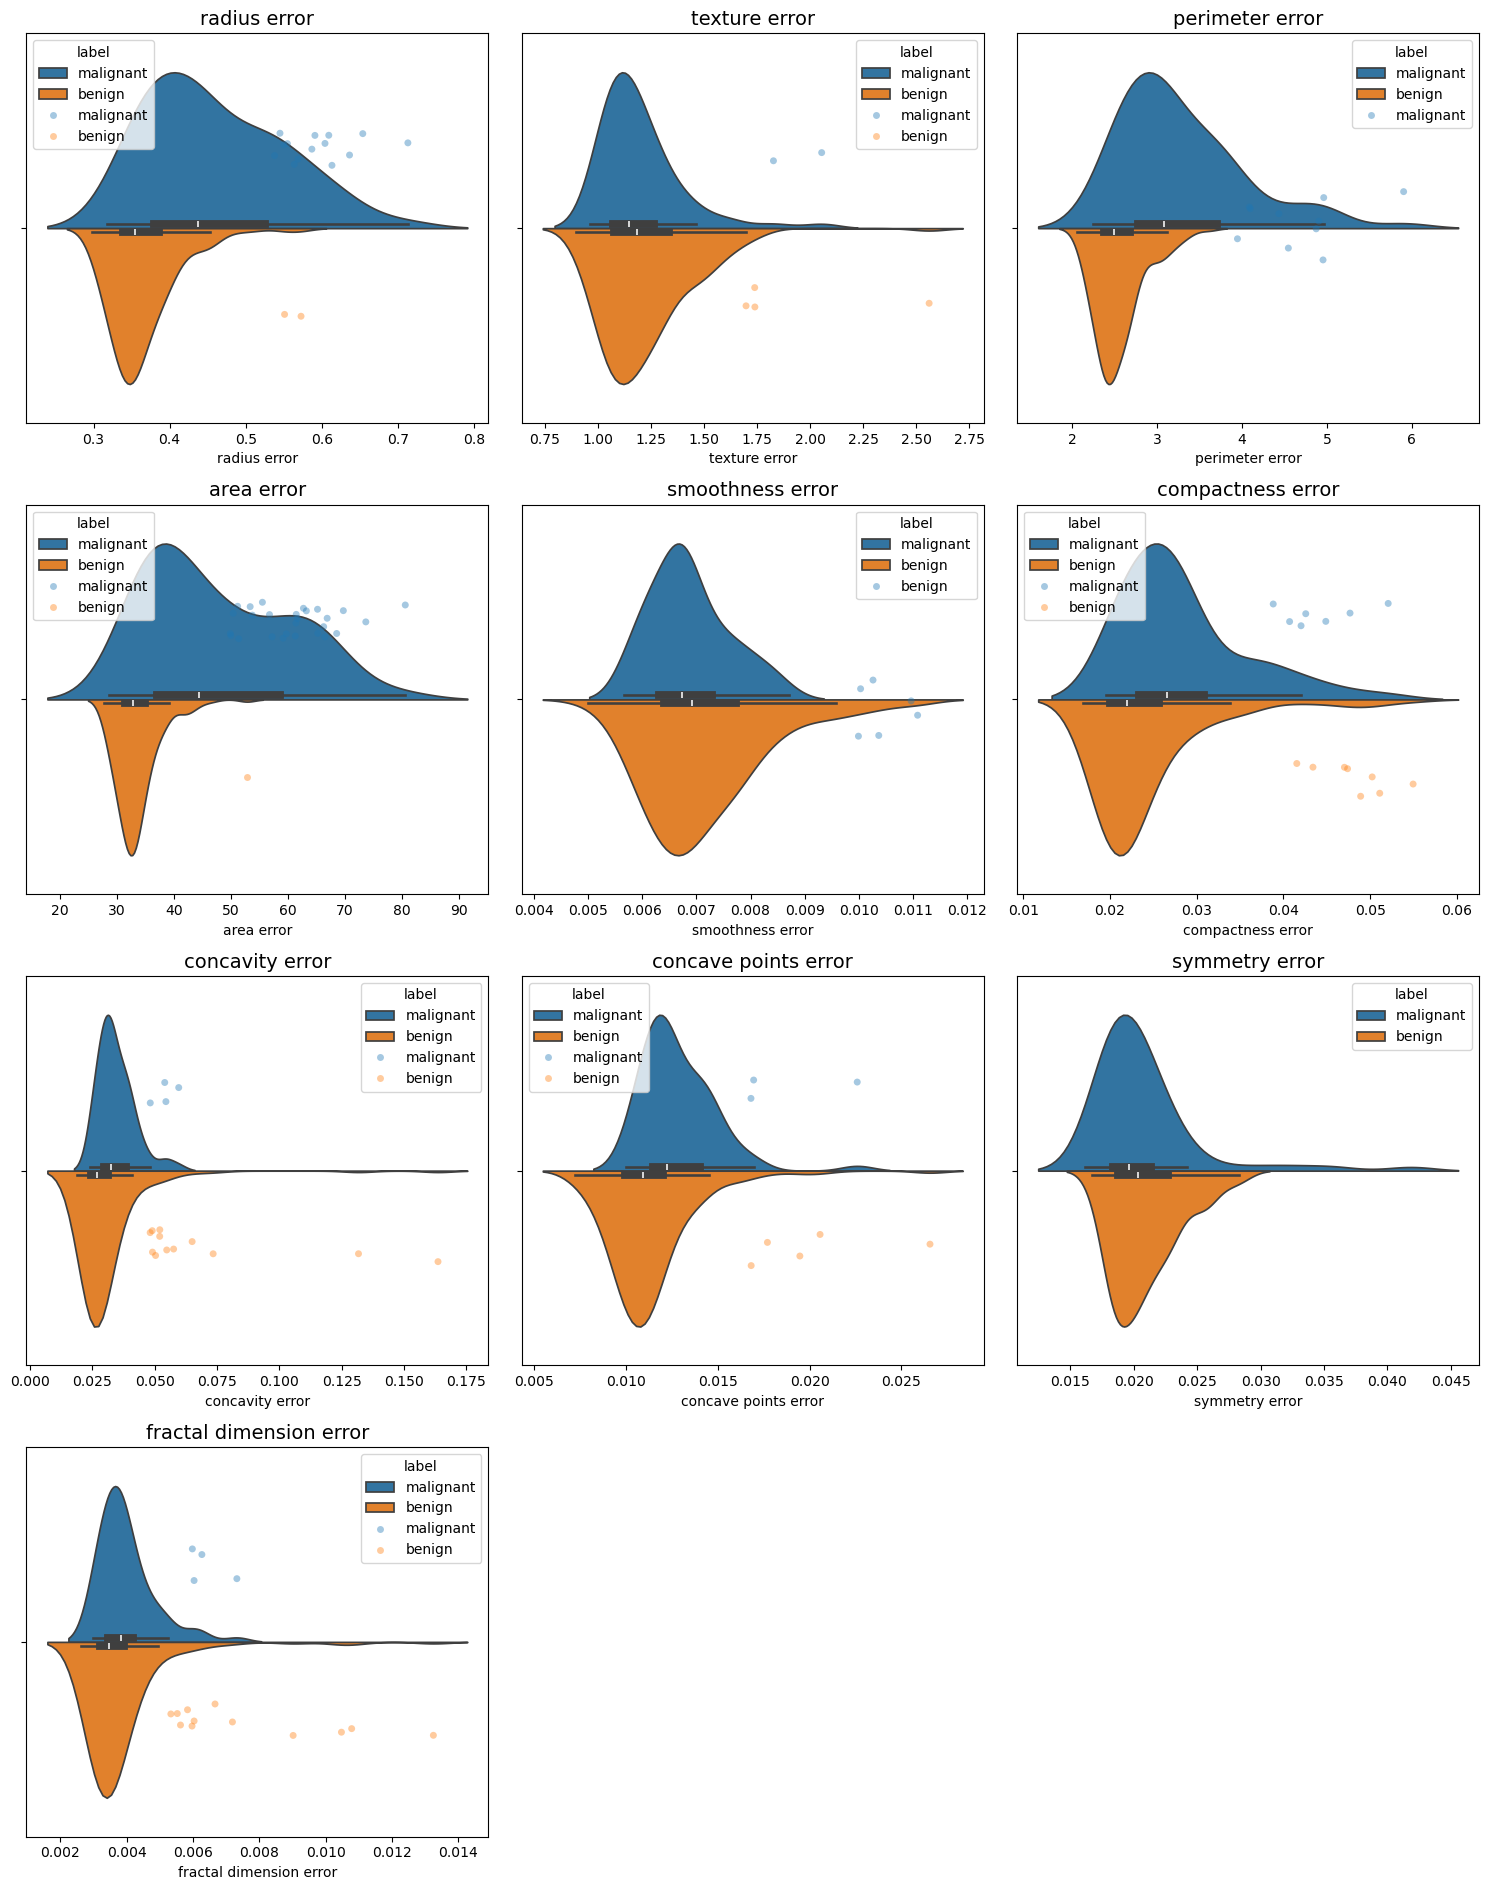

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

In [20]:
# Removing outliers of the "error" features
# We will manually remove problematic outliers and replace these to be with np.nan to be imputed in step 2
df['texture error'] = df['texture error'].apply(lambda x: np.nan if x > 1.75 else x)
df['concavity error'] = df['concavity error'].apply(lambda x: np.nan if x > 0.1 else x)
df['area error'] = df['area error'].apply(lambda x: np.nan if x > 70 else x)
df['concave points error'] = df['concave points error'].apply(lambda x: np.nan if x > 0.022 else x)
df['fractal dimension error'] = df['fractal dimension error'].apply(lambda x: np.nan if x > 0.006 else x)
df['compactness error'] = df['compactness error'].apply(lambda x: np.nan if x > 0.04 else x)
df.loc[(df["smoothness error"] >0.09) & (df["label"] == 'benign'), "mean area"] = np.nan


#### Visualization after Data Cleaning and Outlier Analysis

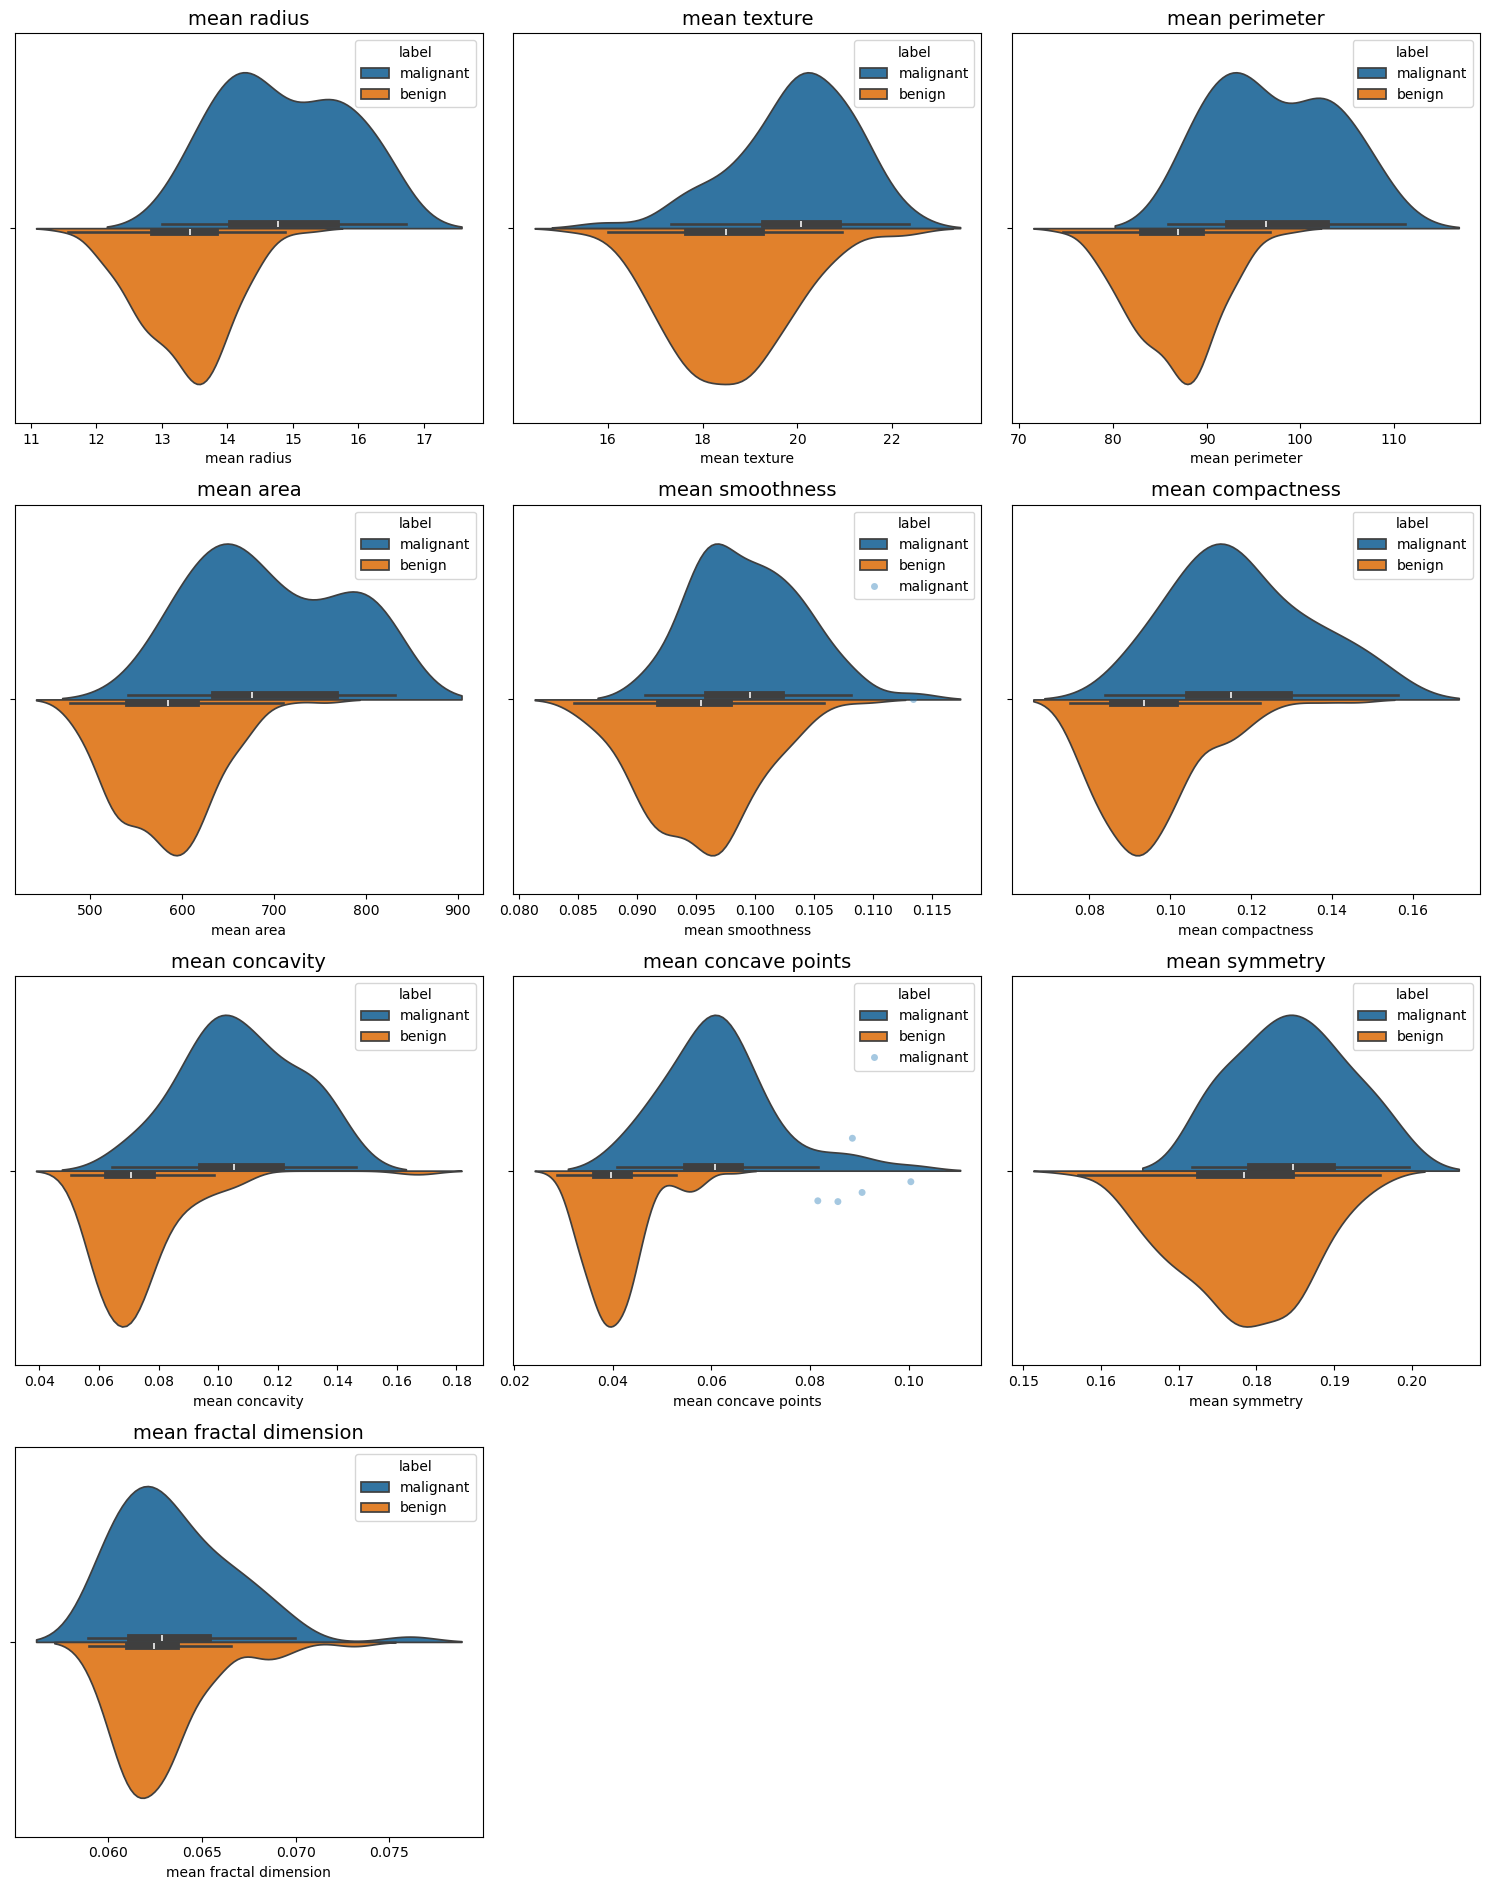

In [21]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'mean' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

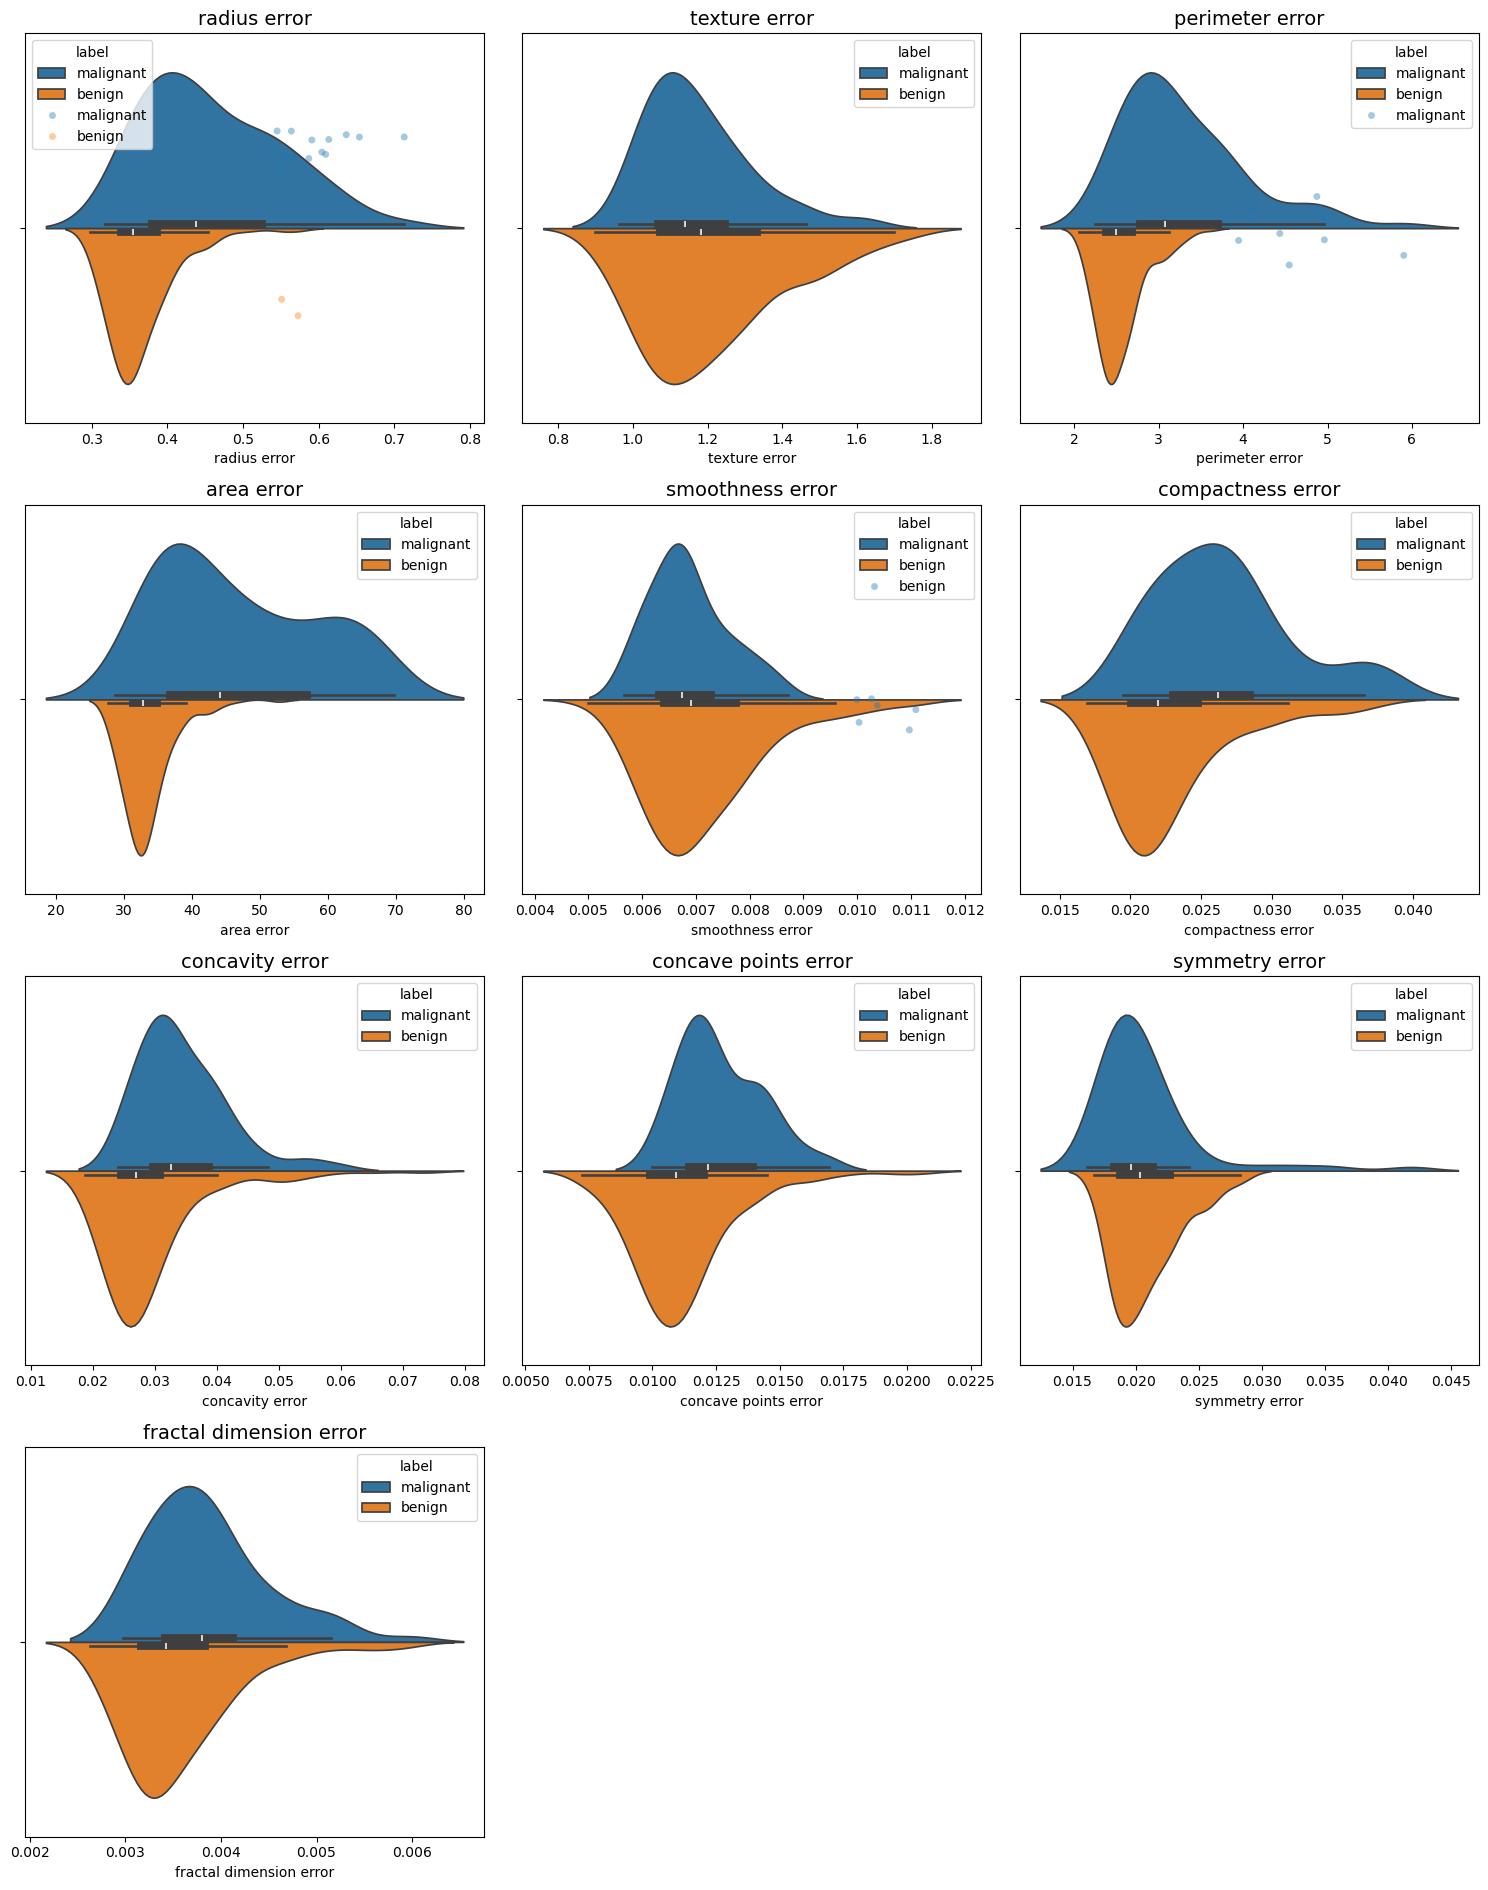

In [22]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjust the figure size as needed

for i, v in enumerate([feature for feature in feature_names if 'error' in feature]):
    row, col = divmod(i, 3)  # Calculate row and column index for the subplot
    ax = axs[row, col]  # Select the appropriate axes for the current plot
    sns.violinplot(data=df, x=v, hue="label", ax=ax, split=True)
    # Identify outliers with IQR
    stats = boxplot_stats(df[v])
    outliers = [item for stat in stats for item in stat['fliers']]
    # Filter df for outliers in the current feature and plot
    sns.stripplot(data=df[df[v].isin(outliers)], x=v, hue="label", ax=ax, alpha=0.4, dodge=True)
    ax.set_title(v, fontsize=14)  # Adjust title font size as needed


total_plots = len([feature for feature in feature_names if 'mean' in feature])
for j in range(total_plots, 4*3):  
    row, col = divmod(j, 3)
    axs[row, col].axis('off')  

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend

plt.show()

In [23]:
### Final step -> transform target into proper binary values
df['label'] = df['label'].apply(lambda x: 1 if x == 'malignant' else 0)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    int64  
 1   mean radius              219 non-null    float64
 2   mean texture             219 non-null    float64
 3   mean perimeter           219 non-null    float64
 4   mean area                210 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         216 non-null    float64
 7   mean concavity           216 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            206 non-null    float64
 10  mean fractal dimension   219 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            217 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area error               2

## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

In [25]:
# Split the data into appropriate train, validaiton and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target], test_size=0.25, random_state=random_seed, stratify=df[target])
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_seed, stratify=y_train)

### Data Preprocessing Definition

In [26]:
# Defining the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

In [27]:
# Some helpful code that you can use if you wish (or not)

from sklearn.metrics import fbeta_score, make_scorer

def f10_score(yt,yp):
    return fbeta_score(yt, yp, beta=10)

def f01_score(yt,yp):
    return fbeta_score(yt, yp, beta=0.1)

f10_scorer = make_scorer(fbeta_score, beta=10)
f01_scorer = make_scorer(fbeta_score, beta=0.1)


In [28]:
def print_baseline_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"fbeta_scores with beta=0.1: {f01_score(y_true, y_pred)}")
    print(f"fbeta_scores with beta=10: {f10_score(y_true, y_pred)}")

### Simple Baseline of Random Predictions

In [29]:
baseline_predictions = np.random.choice([0, 1], size=len(y_train))
print_baseline_metrics(y_train, baseline_predictions)

Accuracy: 0.5151515151515151
Balanced Accuracy: 0.5334782608695652
Recall: 0.58
Precision: 0.32954545454545453
ROC AUC: 0.5334782608695652
F1 Score: 0.42028985507246375
fbeta_scores with beta=0.1: 0.3309604519774011
fbeta_scores with beta=10: 0.5756682389937107


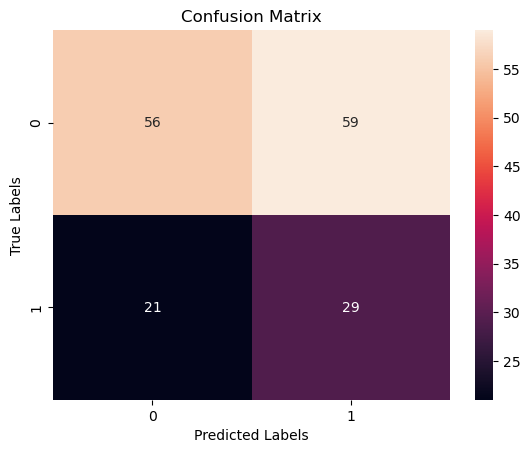

In [30]:
# confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

plot_confusion_matrix(y_train, baseline_predictions)

### Baseline SGD Classifier

In [31]:
from sklearn.linear_model import SGDClassifier

SGD_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessing_pipeline),
    ('SGD', SGDClassifier(random_state=random_seed))
])

Accuracy: 0.9878787878787879
Balanced Accuracy: 0.991304347826087
Recall: 1.0
Precision: 0.9615384615384616
ROC AUC: 0.9913043478260869
F1 Score: 0.9803921568627451
fbeta_scores with beta=0.1: 0.9619047619047619
fbeta_scores with beta=10: 0.9996041171813144


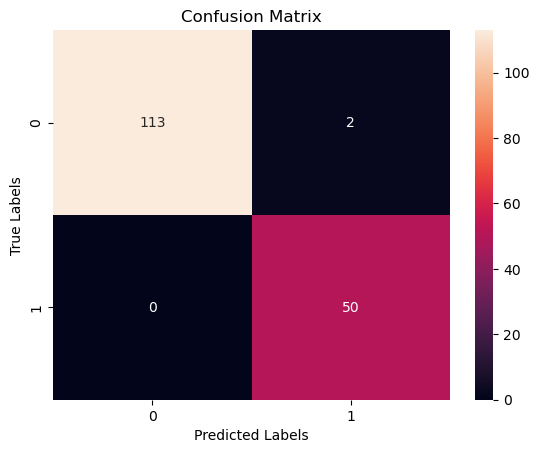

In [32]:
base_sgd_pred = SGD_pipeline.fit(X_train, y_train).predict(X_train)
train_baseline_predictions = SGD_pipeline.predict(X_train)
# print(f"F1 on train set: {f1_score(y_train, train_baseline_predictions)}")
print_baseline_metrics(y_train, base_sgd_pred)
plot_confusion_matrix(y_train, base_sgd_pred)

In [33]:
# Getting Comparable CV Score
cv_score = cross_val_score(SGD_pipeline, X_train, y_train, cv=4, scoring='f1')
print(f"Mean F1 score on CV: {cv_score.mean()}")

Mean F1 score on CV: 0.9080964325529542


## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

The aim of the requirements are at least 90% of detecting malignant cancer when it is present - maximizing Precision, and ensure that no more than 1 in 5 healthy cases result in a false postive - minimizing False Positive Rate. To optimize for a combination of these: use F1-score.

$$ F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} $$

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

#### SGD Classifier

In [34]:
SGD_param_grid = {
    'SGD__loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
    'SGD__penalty': ['l2', 'l1', 'elasticnet'],
    'SGD__alpha': [0.001, 0.01, 0.1],
}

SGD_grid_search = GridSearchCV(SGD_pipeline, SGD_param_grid, cv=4, scoring='f1')

In [35]:
SGD_grid_search.fit(X_train, y_train)

/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Use

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('SGD',
                                        SGDClassifier(random_state=42))]),
             param_grid={'SGD__alpha': [0.001, 0.01, 0.1],
                         'SGD__loss': ['hinge', 'modified_huber',
                                       'squared_hinge', 'perceptron'],
                         'SGD__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='f1')

In [36]:
SGD_best_estimator = SGD_grid_search.best_estimator_
print(SGD_best_estimator)
print(f"mean F1 score of the best estimator in Grid Search: {SGD_grid_search.best_score_}")
print(f"Std. Dev of f1 of estimator: {SGD_grid_search.cv_results_['std_test_score'][SGD_grid_search.best_index_]}")

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('SGD',
                 SGDClassifier(alpha=0.01, penalty='elasticnet',
                               random_state=42))])
mean F1 score of the best estimator in Grid Search: 0.9191666666666667
Std. Dev of f1 of estimator: 0.07484706629743967


F1 score of the best estimator on entire trainset: 0.9591836734693877


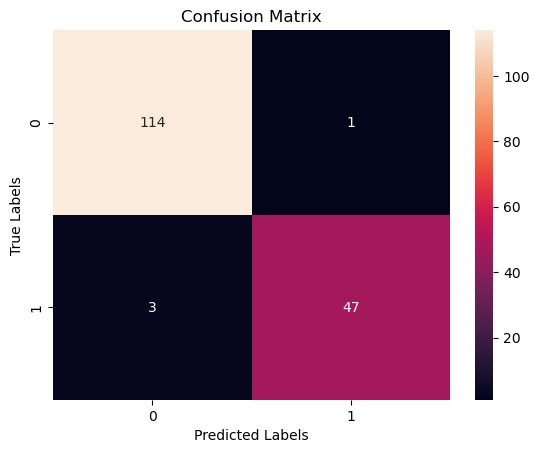

In [37]:
SGD_y_pred = SGD_best_estimator.predict(X_train)
print(f"F1 score of the best estimator on entire trainset: {f1_score(y_train, SGD_y_pred)}")
plot_confusion_matrix(y_train, SGD_y_pred)

#### SVM

In [38]:
from sklearn.svm import SVC
# Define the SVM pipeline
SVM_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessing_pipeline),
    ('SVM', SVC(random_state=random_seed))
])

In [39]:
SVM_param_grid = {
    'SVM__C': [0.1, 1, 5, 10, 20],
    'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'SVM__degree': [1, 2, 3, 4],
    'SVM__gamma': [0.1, 1, 10, 100]
}

SVM_grid_search = GridSearchCV(SVM_pipeline, SVM_param_grid, cv=4, scoring='f1')

In [40]:
SVM_grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('SVM', SVC(random_state=42))]),
             param_grid={'SVM__C': [0.1, 1, 5, 10, 20],
                         'SVM__degree': [1, 2, 3, 4],
                         'SVM__gamma': [0.1, 1, 10, 100],
                         'SVM__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [41]:
SVM_best_estimator = SVM_grid_search.best_estimator_
print(SVM_best_estimator)
print(f"Mean F1 score of the best estimator in Grid Search: {SVM_grid_search.best_score_}")
print(f"Std. Dev of f1 of estimator: {SVM_grid_search.cv_results_['std_test_score'][SVM_grid_search.best_index_]}")

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('SVM',
                 SVC(C=0.1, degree=1, gamma=0.1, kernel='linear',
                     random_state=42))])
Mean F1 score of the best estimator in Grid Search: 0.9323076923076923
Std. Dev of f1 of estimator: 0.05669392545442547


F1 score of the best estimator on entire trainset: 0.9292929292929293


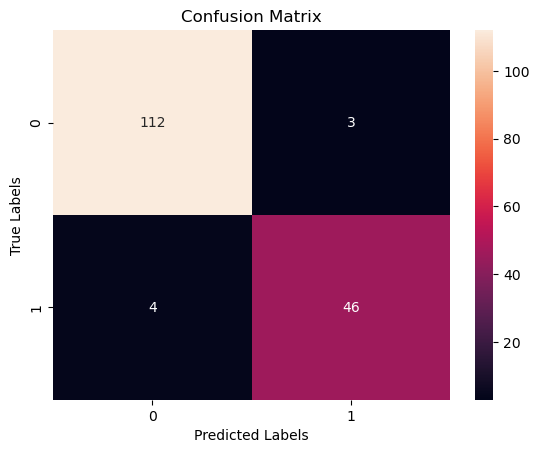

In [42]:
SVM_y_pred = SVM_best_estimator.predict(X_train)
print(f"F1 score of the best estimator on entire trainset: {f1_score(y_train, SVM_y_pred)}")
plot_confusion_matrix(y_train, SVM_y_pred)

#### Random Forest


In [43]:
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessing_pipeline),
    ('RF', RandomForestClassifier(random_state=random_seed, n_jobs = -1))
])

In [44]:
RF_param_grid = {
    'RF__n_estimators': [50, 100, 200, 400],
    'RF__max_depth': [None, 5, 10, 20],
    'RF__criterion': ["gini", "entropy", "log_loss"],
    'RF__max_features': [None, 'sqrt', 'log2'],
    'RF__class_weight': ['balanced', 'balanced_subsample', None]
}

RF_grid_search = GridSearchCV(RF_pipeline, RF_param_grid, cv=4, scoring='f1', n_jobs=-1)

In [45]:
RF_grid_search.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer()),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('RF',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'RF__class_weight': ['balanced', 'balanced_subsample',
                                              None],
                         'RF__criterion': ['gini', 'entropy', 'log_loss'],
                         'RF__max_depth': [None, 5, 10, 20],
                         'RF__max_features': [None, 'sqrt', 'log2'],
                         'RF__n_estimators': [50, 100, 200, 400]},
             scoring='f1')

In [46]:
RF_best_estimator = RF_grid_search.best_estimator_
print(RF_best_estimator)
print(f"Mean F1 score of the best estimator on gridsearch: {RF_grid_search.best_score_}")
print(f"Std. Dev of f1 of estimator: {RF_grid_search.cv_results_['std_test_score'][RF_grid_search.best_index_]}")

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('RF',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_features=None,
                                        n_jobs=-1, random_state=42))])
Mean F1 score of the best estimator on gridsearch: 0.9065663322185062
Std. Dev of f1 of estimator: 0.03558755263053043


F1 score of the best estimator on validation: 1.0


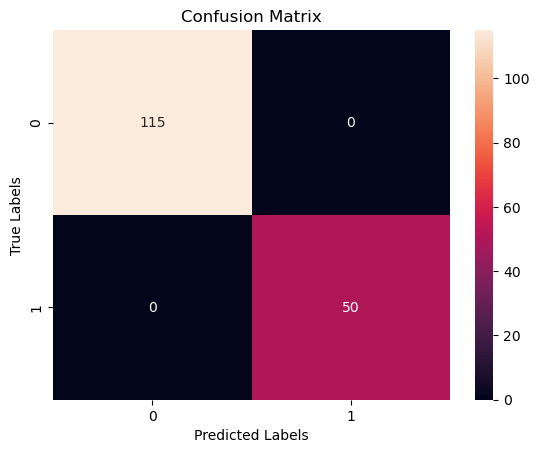

In [47]:
RF_y_pred = RF_best_estimator.predict(X_train)
print(f"F1 score of the best estimator on validation: {f1_score(y_train, RF_y_pred)}")
plot_confusion_matrix(y_train, RF_y_pred)

From the experimentation above, we see that SVM classifier performed the best out of all the other models. We then train it with the full X_train and y_train dataset.

| Model         | Mean F1 from GridSearchCV |
|---------------|-------------|
| Baseline SGD | 0.9098 |
| SGD          | 0.9192
| SVM           | 0.9323     |
| Random Forest | 0.9065      |


In [58]:
best_model = SVM_best_estimator
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', StandardScaler())])),
                ('SVM',
                 SVC(C=0.1, degree=1, gamma=0.1, kernel='linear',
                     random_state=42))])

F1 score of the best estimator on test: 0.896551724137931


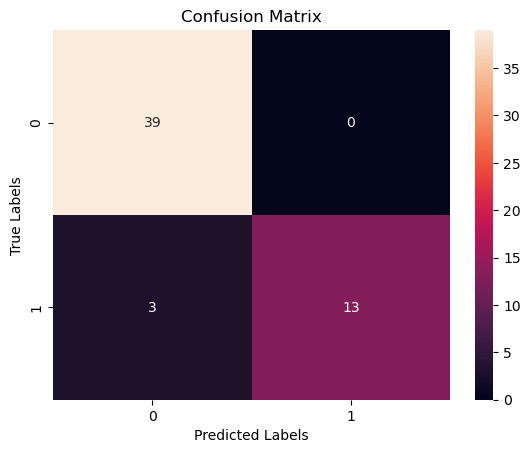

In [59]:
best_model_test_pred = best_model.predict(X_test)
print(f"F1 score of the best estimator on test: {f1_score(y_test, best_model_test_pred)}")
plot_confusion_matrix(y_test, best_model_test_pred)

### 3.3 Final results


From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

In [60]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, best_model_test_pred, labels=[0, 1]).ravel()
print(tn, fp, fn, tp)

39 0 3 13


In [61]:
# We look for getting a predicted of 0, given a true lable of 1
print(f'{fn/(fn+tp)*100}%')

18.75%


## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [62]:
benign = df[df['label'] == 0]
malignant = df[df['label'] == 1]
t_scores = {}
for column in feature_names:
    mean_benign = benign[column].mean()
    mean_malignant = malignant[column].mean()
    std_benign = benign[column].std()
    std_malignant = malignant[column].std()
    t_score = (mean_malignant - mean_benign) / (0.5 * (std_malignant + std_benign))
    t_scores[column] = abs(t_score)

In [63]:
sorted_t_scores = sorted(t_scores.items(), key=lambda x: x[1], reverse=True)
print(sorted_t_scores[:4])

[('mean concave points', np.float64(2.338207079841026)), ('mean perimeter', np.float64(1.9656491051417186)), ('mean concavity', np.float64(1.932435828786661)), ('mean radius', np.float64(1.8482466099087533))]


### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

In [54]:
def make_meshgrid(x, y, ns=100):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on (only min and max used)
    y: data to base y-axis meshgrid on (only min and max used)
    ns: number of steps in grid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    hx = (x_max - x_min)/ns
    hy = (y_max - y_min)/ns
    xx, yy = np.meshgrid(np.arange(x_min, x_max + hx, hx), np.arange(y_min, y_max + hy, hy))
    return xx, yy

In [77]:
def plot_contours(clf, xx, yy, xmean, n1, n2, ax, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    xmean : 1d array of N mean values (used to populate constant features with)
    n1, n2: index numbers of features that change
              that is, which features xx and yy represent, from the set of N features
    params: dictionary of params to pass to contourf, optional
    """
    # The following lines makes an MxN matrix to pass to the classifier (# samples x # features)
    # It does this by multiplying Mx1 and 1xN matrices, where the former is filled with 1's
    #  where M is the number of grid points in xx and N is the number of features in xmean
    #  It is done in such a way that the xmean vector is replaced in each row
    fullx = np.ones((xx.ravel().shape[0],1)) * np.reshape(xmean,(1,-1))
    fullx[:,n1] = xx.ravel()
    fullx[:,n2] = yy.ravel()
    Z = clf.predict(fullx)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out  

In [56]:
from itertools import combinations
best_features = [f[0] for f in sorted_t_scores[:4]]

feature_pairs = list(combinations(best_features, 2))
print(feature_pairs)

[('mean concave points', 'mean perimeter'), ('mean concave points', 'mean concavity'), ('mean concave points', 'mean radius'), ('mean perimeter', 'mean concavity'), ('mean perimeter', 'mean radius'), ('mean concavity', 'mean radius')]


/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/nic/Uni/CS7317/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are 

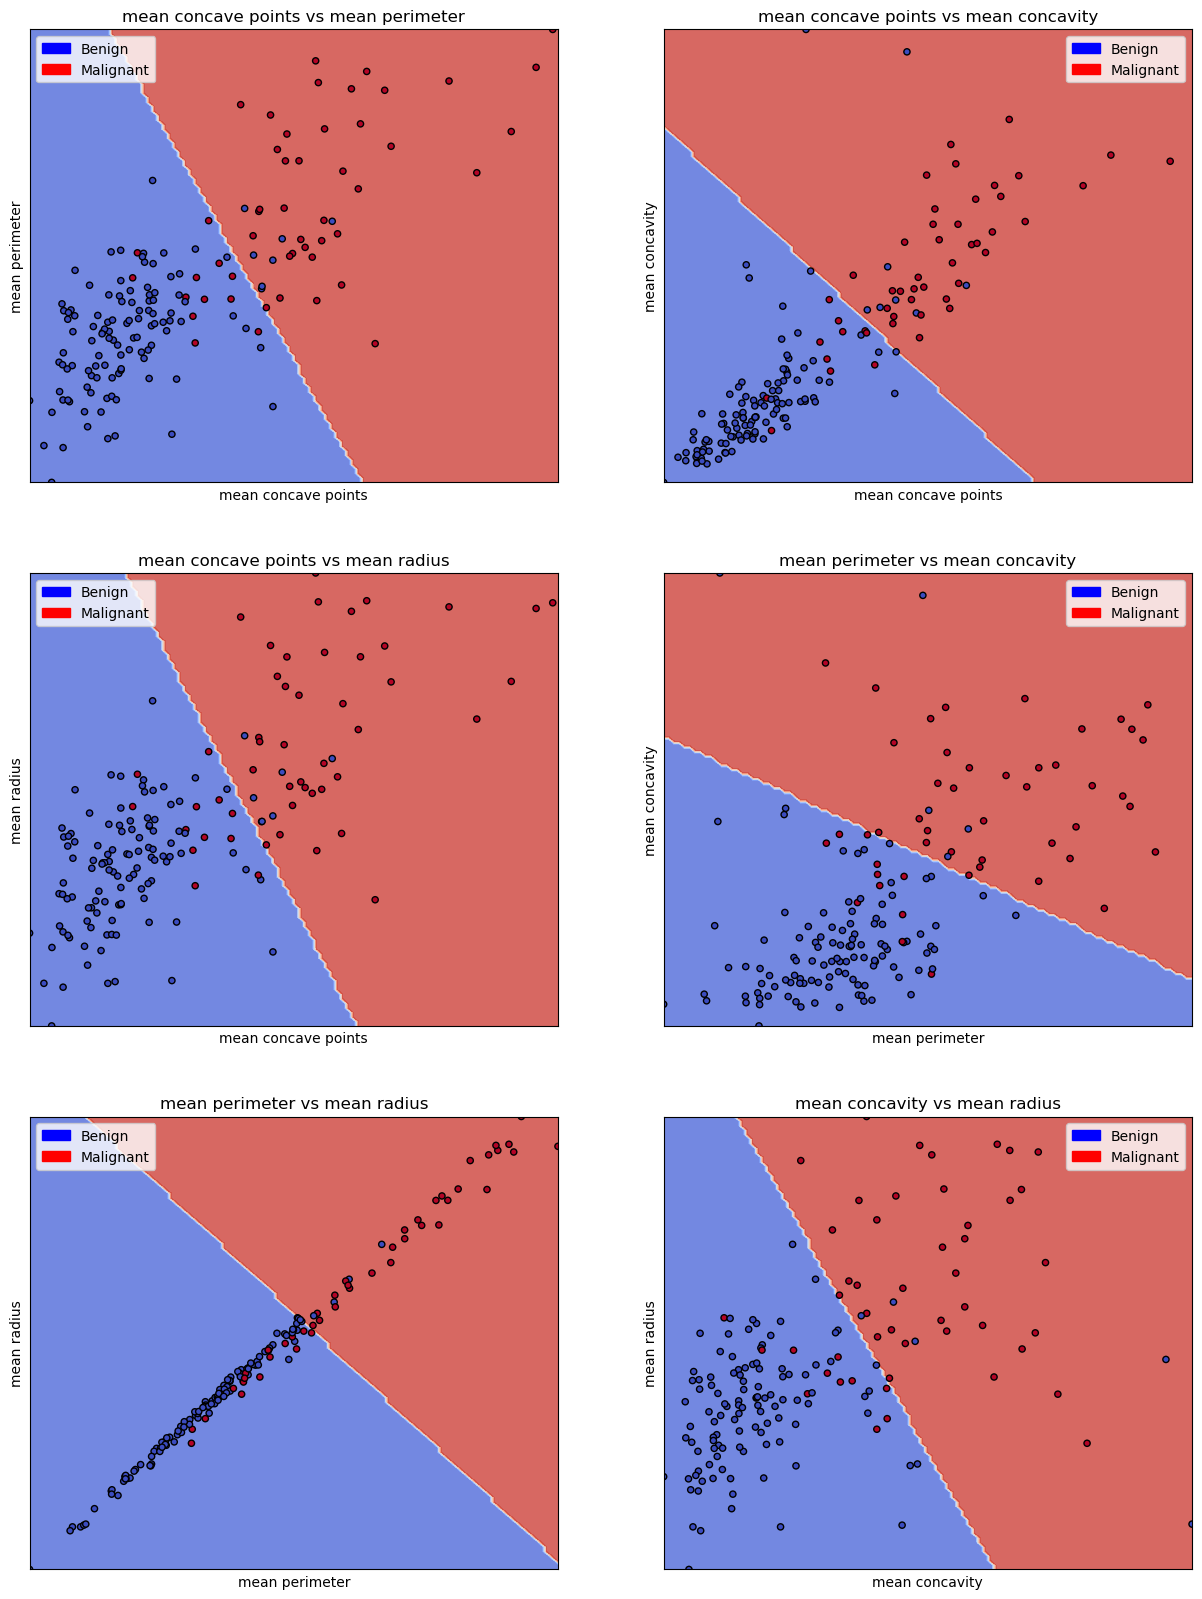

In [82]:
import matplotlib.patches as mpatches
class_means = 0.5 * (benign.iloc[:,1:].mean() + malignant.iloc[:,1:].mean())
fig, axs = plt.subplots(3, 2, figsize=(15, 20))
for i, (x, y) in enumerate(feature_pairs):
    ax = axs[i // 2, i % 2]
    # title for the plots
    title = f"{x} vs {y}"
    # Set-up grid for plotting.
    X0, X1 = X_train[x], X_train[y]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(best_model, xx, yy, class_means, X_train.columns.get_loc(x), X_train.columns.get_loc(y), ax, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.legend(handles=[mpatches.Patch(color='Blue', label='Benign'), mpatches.Patch(color='red', label='Malignant')])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

The two requirements that the client is looking for is for a Recall of 90% and a False Positive Rate below 20%. The final model  does not fulfill the client's criteria because the mean F1 metric of the best model is at 0.9323 with a standard deviation of 0.0567 after cross-fold validation but when generalizing this to the outsample data, we see that the F1 score is at 0.89, but the the Recall of the model is at 81.25% with a False Positive Rate of 0%. The performance of the model only hits one of the two requirements.